In [1]:
import os
import sys
sys.path.insert(0, '..')
import ccal
%matplotlib inline

import numpy as np
import pandas as pd

==================== Computational Cancer Analysis Library ====================
<14:55:08> Checking library dependencies ...
<14:55:08> Using the following libraries (in addition to the Anaconda libraries):
<14:55:08> 	scipy (v0.18.0)
<14:55:08> 	statsmodels (v0.6.1)
<14:55:08> 	scikit-learn (v0.17.1)
<14:55:08> 	seaborn (v0.7.1)
<14:55:08> 	rpy2 (v2.8.2)
<14:55:08> 	pandas (v0.18.1)
<14:55:08> 	matplotlib (v1.5.1)
<14:55:08> 	numpy (v1.11.1)
<14:55:08> Planted a random seed 20121020.


# Make simulation matrix

def add_value(df, inVal, outVal):
    # Add value in cluster
    # Set inVal or outVal to be None when not updating it
    
    for i,(n,s) in enumerate(df.iterrows()):
        #print('add_value:',i)
        for j,c in enumerate(s.index):
            if inVal and n==c:
                df.iloc[i,j]=inVal
            if outVal and n!=c:
                df.iloc[i,j]=outVal

def add_noise(df,inMu,inSigma,outMu,outSigma):
    # Add noise
    
    for i,(n,s) in enumerate(df.iterrows()):
        #print('add_noise:',i)
        for j,c in enumerate(s.index):
            if (inMu or inSigma) and n==c:
                df.iloc[i,j]+=random.gauss(inMu,inSigma)
            if (outMu or outSigma) and n!=c:
                df.iloc[i,j]+=random.gauss(outMu,outSigma)

def mix(df,k,mix):
    # Mix cluster values to nonclusters and vice versa
    
    assert k!=0, print('k cannot be 0')
    
    # Get the number of values in a cluster
    n_k_val=len(df.columns)*len(df.index)/k
    #print('n_k_val:',n_k_val)
    
    # Count
    c=0
    while c<mix*n_k_val:
        
        # Pick 1st random index and column
        r_idx0=random.randint(0,len(df.index)-1)
        r_col0=random.randint(0,len(df.columns)-1)

        # If index and column locate inside a cluster
        if df.index[r_idx0]==df.columns[r_col0]:    
            
            # Get cluster value located
            pick0=df.iloc[r_idx0,r_col0]
            
            # Pick 2nd random index and column
            r_idx1=random.randint(0,len(df.index)-1)
            r_col1=random.randint(0,len(df.columns)-1)
            
            # If index and column locate outside a cluster
            if df.index[r_idx1]!=df.columns[r_col1]:    

                # Get non-cluster value located
                pick1=df.iloc[r_idx1,r_col1]

                # Swap
                df.iloc[r_idx0,r_col0]=pick1
                df.iloc[r_idx1,r_col1]=pick0
                
                # Count
                c+=1
                
                #print('Swapped (%s,%s) & (%s,%s)'%(df.index[r_idx0],df.columns[r_col0],df.index[r_idx1],df.columns[r_col1]))

def initialize_simulation_df(df,inVal,inMu,inSigma,outVal,outMu,outSigma,mix):
    # Initialize values in and out of a cluster and add noise
    
    t0=time()
    
    # For each row
    for i,(n,s) in enumerate(df.iterrows()):
        print('initialize_simulation_df:',i)
        
        # For each column
        for j,c in enumerate(s.index):
            r=random.random()
            
            if mix and r<=mix:
                # Mix
                if n==c:
                    # In cluster gets out-value
                    df.iloc[i,j]=outVal
                    if outMu or outSigma:
                        df.iloc[i,j]+=random.gauss(outMu,outSigma)
                else:
                    # Out cluster gets in-value
                    df.iloc[i,j]=inVal
                    if inMu or inSigma:
                        df.iloc[i,j]+=random.gauss(inMu,inSigma) 
            else:
                # No mix
                if n==c:
                    # In cluster gets in-value
                    df.iloc[i,j]=inVal
                    if inMu or inSigma:
                        df.iloc[i,j]+=random.gauss(inMu,inSigma)
                else:
                    # Out cluster gets out-value
                    df.iloc[i,j]=outVal
                    if outMu or outSigma:
                        df.iloc[i,j]+=random.gauss(outMu,outSigma)
    print('initialize_simulation_df: done in %0.3fs.'%(time()-t0))

def plot_mtrx(mtrx):
    # Plot simulation matrix
    
    plt.imshow(mtrx,interpolation='nearest',cmap=plt.cm.ocean)
    plt.colorbar()
    plt.show()
    
def make_mtrx_sample_x_variable_simulation(n_sample,
                                           n_var,
                                           k,
                                           val_in,
                                           val_out,
                                           noise_in_mu=None,
                                           noise_in_sigma=None,
                                           noise_out_mu=None,
                                           noise_out_sigma=None,
                                           noise_mix=None,
                                           prefix_out_f=None,
                                           suffix_out_f=None,
                                           plot=False):
    """
    Make sample x variable matrix
    """
    assert k != 0, 'k cannot be 0'
    assert k <= n_var,'k cannot be greater than n_var'
    
    # Make an empty sample x variable matrix filled with 0
    mtrx_sample_x_var = pd.DataFrame(index=range(n_sample), columns=range(n_var)).fillna(0)

    # Slice dataframe index and column and make lists of dataframe indexes and columns for each index and column slice
    list_index_slice = toolK.slice_list(mtrx_sample_x_var.index, k)
    list_column_slice = toolK.slice_list(mtrx_sample_x_var.columns, k)

    # Make index and column slice x dataframe indexes dictionaries
    dict_index_slice = {}
    for i, l in enumerate(list_index_slice):
        dict_index_slice[i] = l
    dict_column_slice = {}
    for i, l in enumerate(list_column_slice):
        dict_column_slice[i] = l

    # Set dataframe index and column to be index and column slice indices respectively
    index=list(mtrx_sample_x_var.index)
    for i,l in dict_index_slice.items():
        for j in l:
            index[j]=i
    mtrx_sample_x_var.index=index
    columns=list(mtrx_sample_x_var.columns)
    for i,l in dict_column_slice.items():
        for j in l:
            columns[j]=i
    mtrx_sample_x_var.columns=columns

    # Initialize simulation matrix
    initialize_simulation_df(mtrx_sample_x_var,val_in,noise_in_mu,noise_in_sigma,val_out,noise_out_mu,noise_out_sigma,noise_mix)
    
    # Save
    if prefix_out_f:        
        mtrx_sample_x_var.to_csv(prefix_out_f+'_sample_%s_var_%s_k_%s_mix_%s_%s'%(n_sample,n_var,k,noise_mix,suffix_out_f),sep='\t')
    
    # Plot
    if plot:
        plot_mtrx(mtrx_sample_x_var)

# Make simulation matrix

# Set number of samples
list_n_sample = [100, 500, 1000, 5000]
# Set number of variables
list_n_var = [100, 500, 1000, 5000]
# Set values in clusters
val_in = 1
# Set values out of clusters
val_out = 0
# Set Ks
list_k = [1, 2, 3, 4, 5, 6, 10, 15, 20, 25]
# Set the fractions of cluster values to be swapped between clusters and nonclusters
list_noise_mix = [0, 0.05, 0.1, 0.2]
# Set noise in clusters
noise_in_mu = 0
noise_in_sigma = 0.1 * noise_in_mu
# Set noise out of clusters
noise_out_mu = 0
noise_out_sigma = 0.1*noise_out_mu

# Simulate
for sample in list_n_sample:
    print('sample:',sample)
    
    for var in list_n_var:
        print('\tvar:',var)
        
        for k in list_k:
            print('\t\tk:',k)
            
            for noise_mix in list_noise_mix:
                print('\t\t\tnoise_mix:',noise_mix)
                
                make_mtrx_sample_x_variable_simulation(sample,
                                                       var,
                                                       k,
                                                       val_in,
                                                       val_out,
                                                       noise_mix=noise_mix,
                                                       prefix_out_f='/cellar/users/hyeerna/aLL/mtrx_sample_x_var_simulation/test/',
                                                       suffix_out_f='sfx',
                                                       plot=True)

In [2]:
A = ccal.support.read_gct('/home/cyborg/hematopoietic_cancer/data/ccle_hema/ccle_hema_gene_filtered.gct')

In [3]:
nmf_results = ccal.analyze.nmf(A, range(3, 21, 3))

<14:55:08> NMF with k=3 ...
<14:55:08> NMF with k=6 ...
<14:55:08> NMF with k=9 ...
<14:55:08> NMF with k=12 ...
<14:55:08> NMF with k=15 ...
<14:55:09> NMF with k=18 ...


In [4]:
nmf_results, nmf_scores = ccal.analyze.nmf_and_score(A, range(3, 21, 3))

<14:55:09> Computing NMF score for k=3 using cophenetic correlation ...
<14:55:09> NMF clustering (0/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> 	Saved the 1st NMF decomposition for k=3.
<14:55:09> NMF clustering (1/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (2/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (3/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (4/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (5/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (6/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (7/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (8/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (9/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (10/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (11/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (12/30) ...
<14:55:09> NMF with k=3 ...
<14:55:09> NMF clustering (

<14:55:23> '-0-' normalizing pandas object with axis=0 ...
<14:55:23> '-0-' normalizing pandas object with axis=1 ...


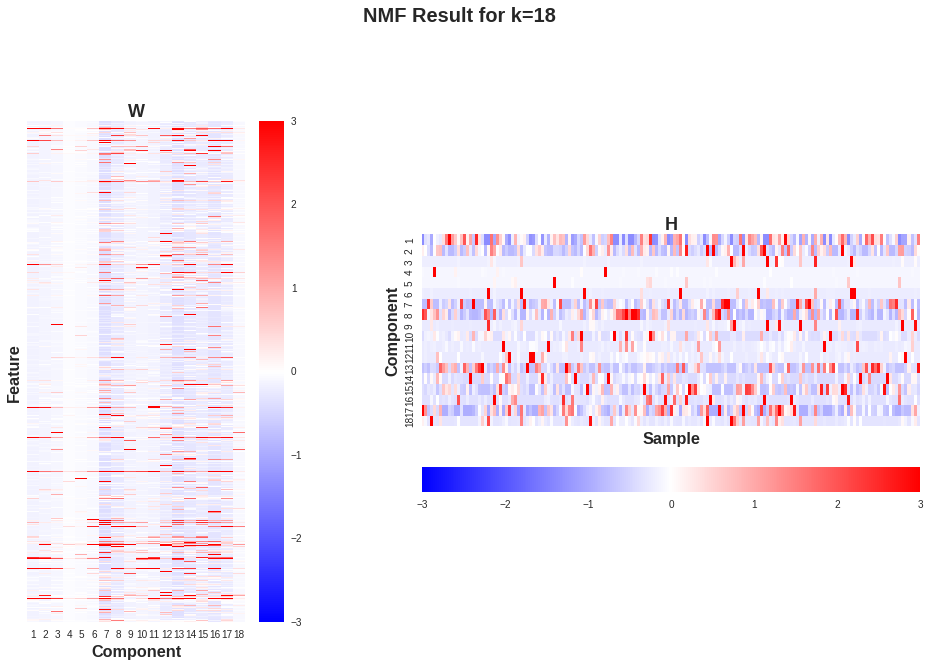

<14:55:33> '-0-' normalizing pandas object with axis=0 ...
<14:55:33> '-0-' normalizing pandas object with axis=1 ...


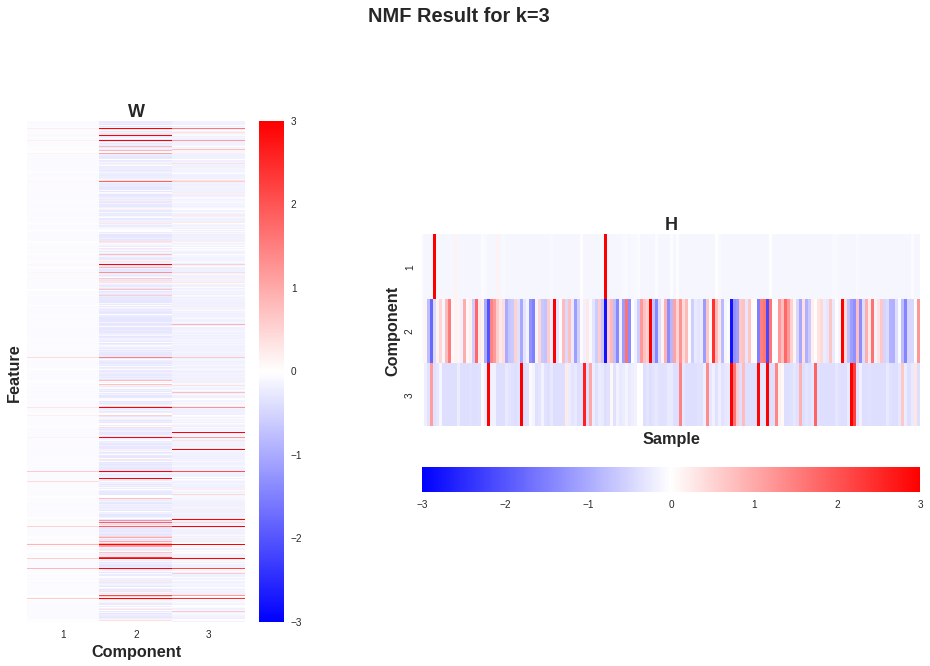

<14:55:37> '-0-' normalizing pandas object with axis=0 ...
<14:55:37> '-0-' normalizing pandas object with axis=1 ...


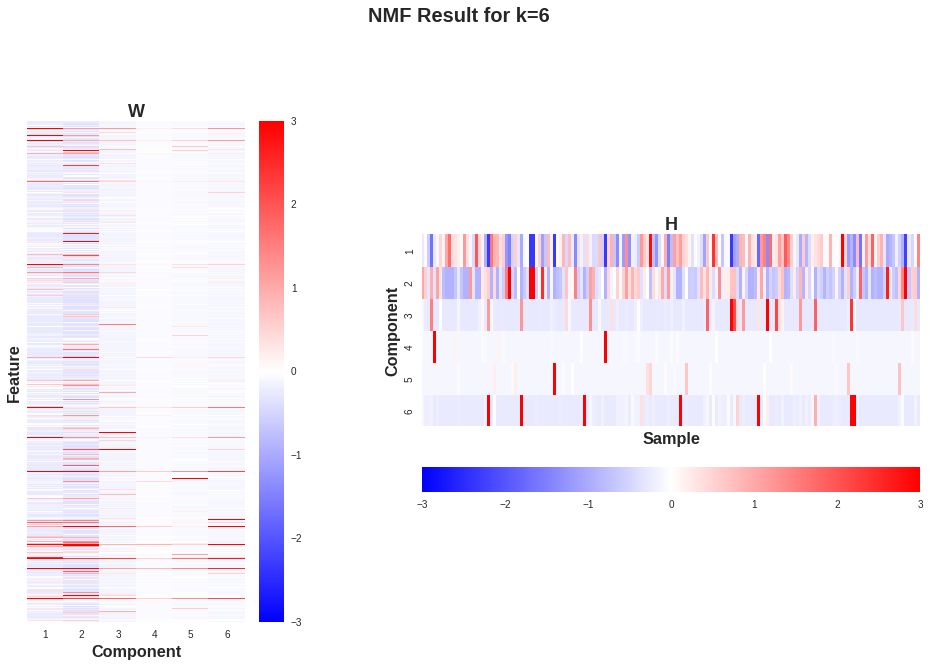

<14:55:41> '-0-' normalizing pandas object with axis=0 ...
<14:55:41> '-0-' normalizing pandas object with axis=1 ...


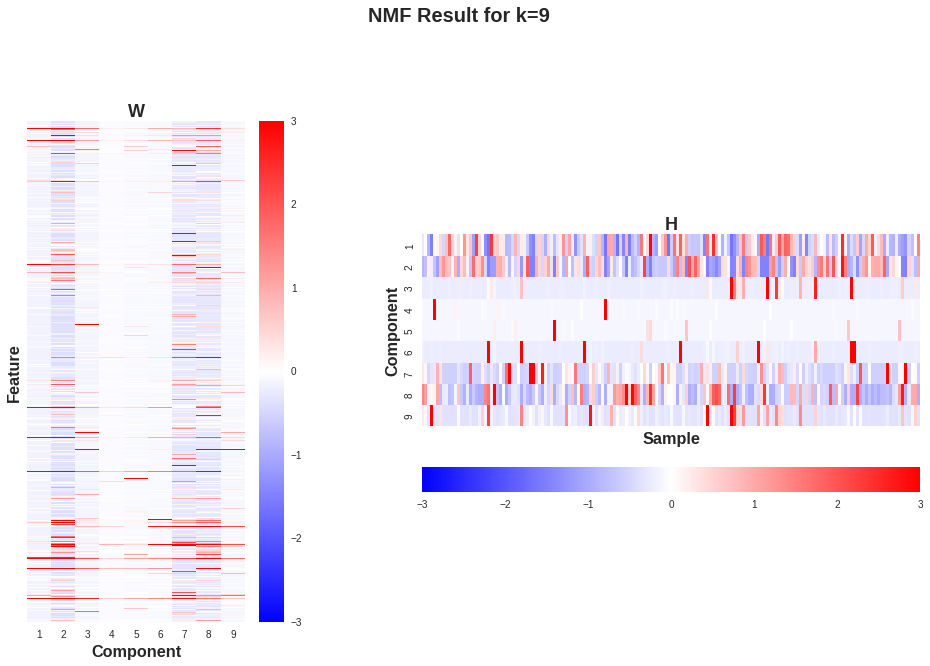

<14:55:47> '-0-' normalizing pandas object with axis=0 ...
<14:55:48> '-0-' normalizing pandas object with axis=1 ...


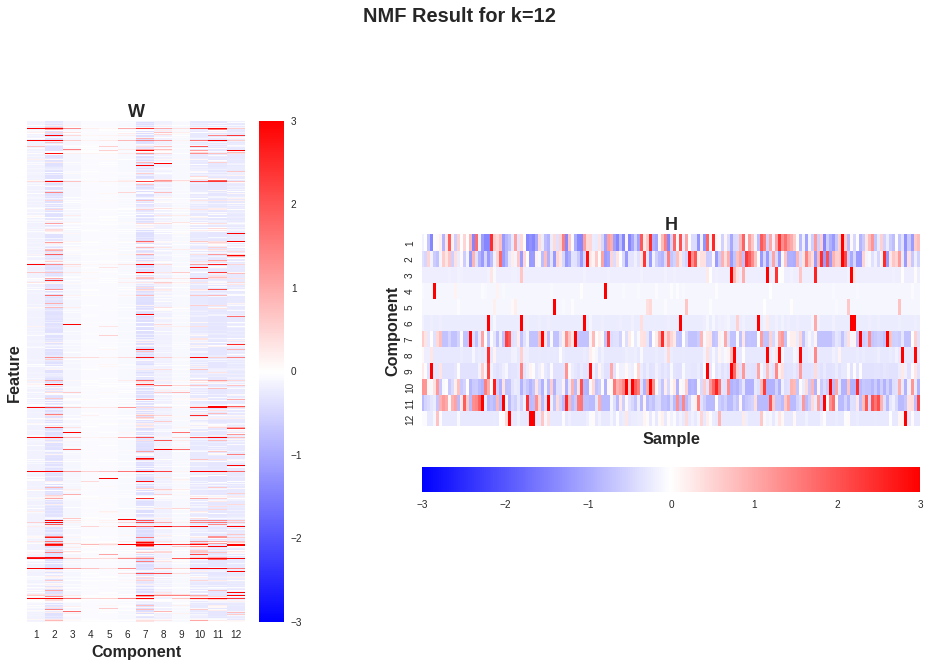

<14:55:55> '-0-' normalizing pandas object with axis=0 ...
<14:55:55> '-0-' normalizing pandas object with axis=1 ...


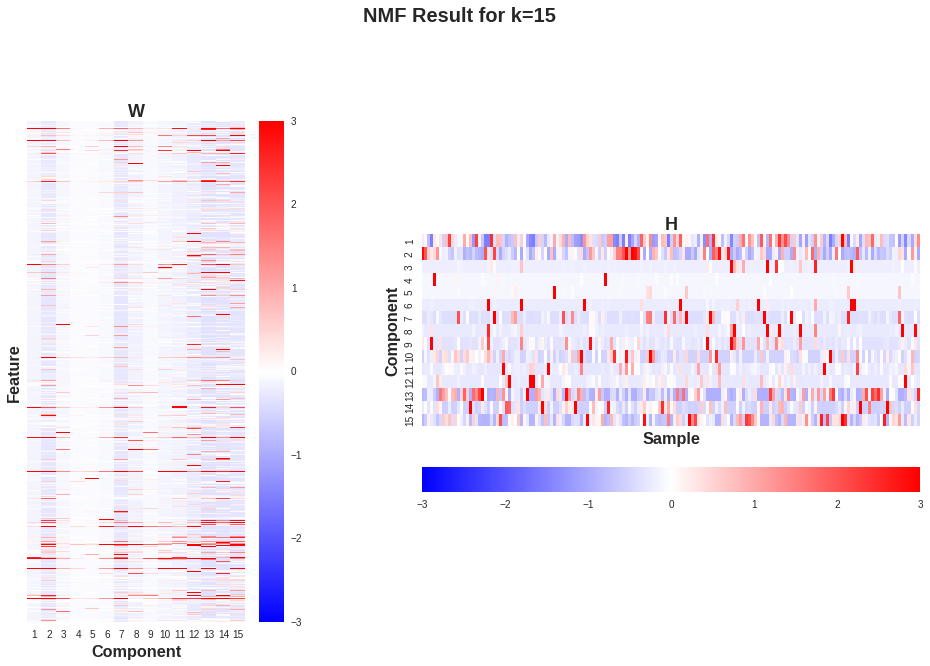

In [5]:
for k in nmf_results.keys():
    ccal.visualize.plot_nmf_result(nmf_results, k, output_filepath='output/nmf_k={}.pdf'.format(k))

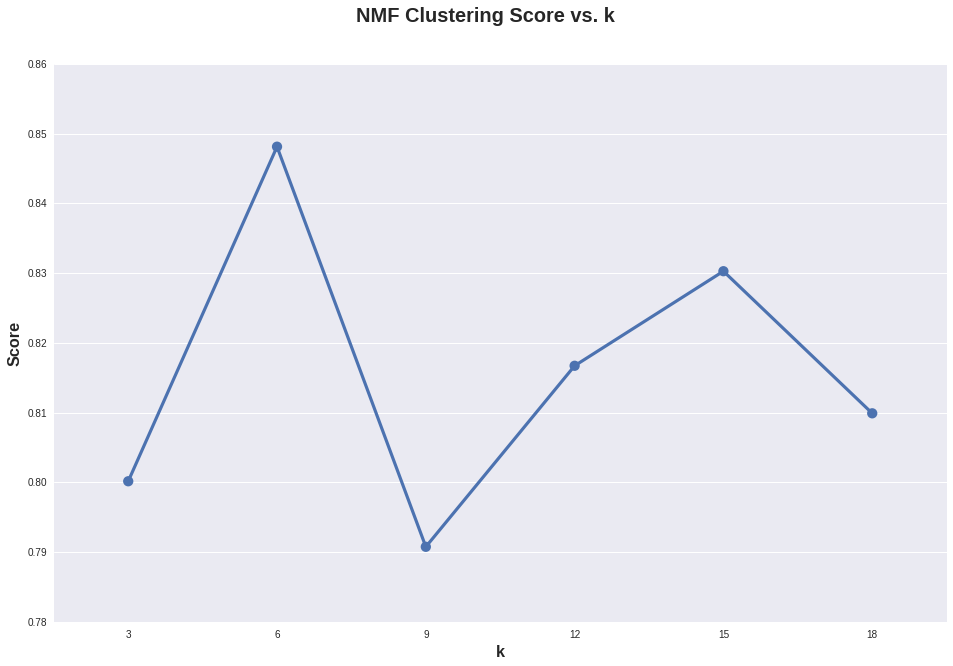

In [7]:
ccal.visualize.plot_nmf_scores(nmf_scores, output_filepath='output/nmf_scores.pdf')